In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import csv
import random
import os
import re
import unicodedata
from io import open
import itertools
import math
import json

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from convokit import Corpus, download

corpus = Corpus(filename=download("movie-corpus"))

In [4]:
corpus.print_summary_stats()

Number of Speakers: 9035
Number of Utterances: 304713
Number of Conversations: 83097


In [5]:
utt = corpus.random_utterance()
print(utt)

Utterance(id: 'L438276', conversation_id: L438272, reply-to: L438275, speaker: Speaker(id: 'u7001', vectors: [], meta: ConvoKitMeta({'character_name': 'DOOLITTLE', 'movie_idx': 'm468', 'movie_name': 'pearl harbor', 'gender': '?', 'credit_pos': '?'})), timestamp: None, text: 'No baseball diamonds, Red.', vectors: [], meta: ConvoKitMeta({'movie_id': 'm468', 'parsed': [{'rt': 2, 'toks': [{'tok': 'No', 'tag': 'DT', 'dep': 'det', 'up': 1, 'dn': []}, {'tok': 'baseball', 'tag': 'NN', 'dep': 'nsubj', 'up': 2, 'dn': [0]}, {'tok': 'diamonds', 'tag': 'NNS', 'dep': 'ROOT', 'dn': [1, 3, 4, 5]}, {'tok': ',', 'tag': ',', 'dep': 'punct', 'up': 2, 'dn': []}, {'tok': 'Red', 'tag': 'NNP', 'dep': 'npadvmod', 'up': 2, 'dn': []}, {'tok': '.', 'tag': '.', 'dep': 'punct', 'up': 2, 'dn': []}]}]}))


In [6]:
# primary data fields
print("ID:", utt.id, "\n")
print("Reply_to:", utt.reply_to, "\n")
print("Timestamp:", utt.timestamp, "\n")
print("Text:", utt.text, "\n")
print("Conversation ID:", utt.conversation_id, "\n")
print("Speaker ID:", utt.speaker.id)

ID: L438276 

Reply_to: L438275 

Timestamp: None 

Text: No baseball diamonds, Red. 

Conversation ID: L438272 

Speaker ID: u7001


In [7]:
convo = corpus.random_conversation()
print(convo)
print()
convo.meta

Conversation('id': 'L82415', 'utterances': ['L82416', 'L82415'], 'meta': ConvoKitMeta({'movie_idx': 'm267', 'movie_name': 'being john malkovich', 'release_year': '1999', 'rating': '7.90', 'votes': '115008', 'genre': "['comedy', 'drama', 'fantasy', 'romance']"}))



ConvoKitMeta({'movie_idx': 'm267', 'movie_name': 'being john malkovich', 'release_year': '1999', 'rating': '7.90', 'votes': '115008', 'genre': "['comedy', 'drama', 'fantasy', 'romance']"})

In [8]:
len(corpus.conversations)

83097

In [10]:
corpus.conversations['L82415']

Conversation({'obj_type': 'conversation', 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x31c088880>, 'id': 'L82415', 'meta': ConvoKitMeta({'movie_idx': 'm267', 'movie_name': 'being john malkovich', 'release_year': '1999', 'rating': '7.90', 'votes': '115008', 'genre': "['comedy', 'drama', 'fantasy', 'romance']"})})

In [13]:
print(next(corpus.iter_utterances()))

Utterance(id: 'L1045', conversation_id: L1044, reply-to: L1044, speaker: Speaker(id: 'u0', vectors: [], meta: ConvoKitMeta({'character_name': 'BIANCA', 'movie_idx': 'm0', 'movie_name': '10 things i hate about you', 'gender': 'f', 'credit_pos': '4'})), timestamp: None, text: 'They do not!', vectors: [], meta: ConvoKitMeta({'movie_id': 'm0', 'parsed': [{'rt': 1, 'toks': [{'tok': 'They', 'tag': 'PRP', 'dep': 'nsubj', 'up': 1, 'dn': []}, {'tok': 'do', 'tag': 'VBP', 'dep': 'ROOT', 'dn': [0, 2, 3]}, {'tok': 'not', 'tag': 'RB', 'dep': 'neg', 'up': 1, 'dn': []}, {'tok': '!', 'tag': '.', 'dep': 'punct', 'up': 1, 'dn': []}]}]}))


In [45]:
conversation_texts = {}

for conv_id in corpus.get_conversation_ids():
    utt_list = []
    for utt_id in corpus.get_conversation(conv_id).get_utterance_ids():
        utt = corpus.get_utterance(utt_id)
        utt_list.append((utt.text.strip(), utt_id))
    conversation_texts[conv_id] = [x[0] for x in sorted(utt_list, key=lambda x: x[1])]

In [46]:
len(conversation_texts)

83097

In [47]:
for key in list(conversation_texts.keys())[:5]:
    print(key, conversation_texts[key])

L1044 ['They do to!', 'They do not!']
L984 ['She okay?', 'I hope so.']
L924 ['Wow', "Let's go."]
L870 ['I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?', 'No', "Okay -- you're gonna need to learn how to lie."]
L866 ["I figured you'd get to the good stuff eventually.", 'What good stuff?', 'The "real you".', 'Like my fear of wearing pastels?']


In [48]:
corpus.get_conversation('L1044').print_conversation_structure(lambda utt: utt.text + "\n")

They do to!

    They do not!



In [49]:
corpus.get_conversation('L984').print_conversation_structure(lambda utt: utt.text + "\n")

She okay?

    I hope so.



In [50]:
corpus.get_conversation('L924').print_conversation_structure(lambda utt: utt.text + "\n")

Wow

    Let's go.



In [51]:
corpus.get_conversation('L870').print_conversation_structure(lambda utt: utt.text + "\n")

I'm kidding.  You know how sometimes you just become this "persona"?  And you don't know how to quit?

    No

        Okay -- you're gonna need to learn how to lie.



In [52]:
corpus.get_conversation('L866').print_conversation_structure(lambda utt: utt.text + "\n")

I figured you'd get to the good stuff eventually.

    What good stuff?

        The "real you".

            Like my fear of wearing pastels?



In [53]:
def extract_conv_pairs(conversation_texts):
    all_pairs = []
    for conv_id in conversation_texts:
        for i in range(len(conversation_texts[conv_id]) - 1):
            all_pairs.append((conversation_texts[conv_id][i], conversation_texts[conv_id][i+1]))
    return all_pairs

all_conv_pairs = extract_conv_pairs(conversation_texts)

print(len(all_conv_pairs))
print(all_conv_pairs[:10])

221616
[('They do to!', 'They do not!'), ('She okay?', 'I hope so.'), ('Wow', "Let's go."), ('I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?', 'No'), ('No', "Okay -- you're gonna need to learn how to lie."), ("I figured you'd get to the good stuff eventually.", 'What good stuff?'), ('What good stuff?', 'The "real you".'), ('The "real you".', 'Like my fear of wearing pastels?'), ('do you listen to this crap?', 'What crap?'), ('What crap?', "Me.  This endless ...blonde babble. I'm like, boring myself.")]


In [54]:
import pathlib
data_root = f"{pathlib.Path.home()}/Projects/AI-ML/datasets/nlp_data"

datafile = os.path.join(data_root, "formatted_movie_lines.txt")

In [55]:
import codecs

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in all_conv_pairs:
        writer.writerow(pair)


Writing newly formatted file...


In [56]:
def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

In [57]:
print("\nSample lines from file:")
printLines(datafile)


Sample lines from file:
b'They do to!\tThey do not!\n'
b'She okay?\tI hope so.\n'
b"Wow\tLet's go.\n"
b'"I\'m kidding.  You know how sometimes you just become this ""persona""?  And you don\'t know how to quit?"\tNo\n'
b"No\tOkay -- you're gonna need to learn how to lie.\n"
b"I figured you'd get to the good stuff eventually.\tWhat good stuff?\n"
b'What good stuff?\t"The ""real you""."\n'
b'"The ""real you""."\tLike my fear of wearing pastels?\n'
b'do you listen to this crap?\tWhat crap?\n'
b"What crap?\tMe.  This endless ...blonde babble. I'm like, boring myself.\n"


In [66]:
PAD_token = 0
SOS_token = 1
EOS_token = 2

class Vocabulary:

    def __init__(self, name) -> None:
        
        self.name = name
        self.trimed = 0
        self.reset()

    def reset(self):
        self.word2index = {}
        self.index2word = {EOS_token: "<EOS>", SOS_token: "<SOS>", PAD_token: "<PAD>"}
        self.word2count = {}
        self.n_words = 3

    def addWord(self, word):
        if word in self.word2count:
            self.word2count[word] += 1
        else:
            self.word2count[word] = 1
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.n_words += 1

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def trim(self, min_count):
        if self.trimed >= min_count:
            return
        self.trimed = min_count

        keep_words = []

        for k, v in self.word2count.items():
            if v >= self.trimed:
                keep_words.append((k, v))

        print("keep_words {} / {} = {:.4f}".format(
            len(keep_words), len(self.word2count), float(len(keep_words)) / len(self.word2count)
        ))

        self.reset()

        for word, count in keep_words:
            self.addWord(word)
            self.word2count[word] = count

    def encode(self, sentence):
        return [self.word2index[word] for word in sentence.split(' ')] + [EOS_token]
    
    def decode(self, ids):
        words = []
        for idx in ids:
            if idx == EOS_token:
                break
            else:
                words.append(self.index2word[idx])
        return words

In [67]:
MAX_LENGTH = 10  # Maximum sentence length to consider

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

In [68]:
# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Vocabulary(corpus_name)
    return voc, pairs


# Returns True if both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using the ``filterPair`` condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus_name, datafile):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.n_words)
    return voc, pairs

In [69]:
voc, pairs = loadPrepareData("movie-corpus", datafile)
# Print some pairs to validate
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221616 sentence pairs
Trimmed to 64585 sentence pairs
Counting words...
Counted words: 18093

pairs:
['they do to !', 'they do not !']
['she okay ?', 'i hope so .']
['wow', 'let s go .']
['what good stuff ?', 'the real you .']
['the real you .', 'like my fear of wearing pastels ?']
['do you listen to this crap ?', 'what crap ?']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['have fun tonight ?', 'tons']


In [70]:
MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 7837 / 18090 = 0.4332
Trimmed from 64585 pairs to 53386, 0.8266 of total


# Batch data

[padded_batch_of_sequences](https://stackoverflow.com/questions/51030782/why-do-we-pack-the-sequences-in-pytorch)

![Padded batch](images/batch-padded.png)

> So, the data preparation work should be complete by now, right? Not really.. Because there is still one pressing problem, mainly in terms of how much compute do we have to do when compared to the actually required computations.
> 
> For the sake of understanding, let's also assume that we will matrix multiply the above padded_batch_of_sequences of shape (6, 9) with a weight matrix W of shape (9, 3).
>
> Thus, we will have to perform 6x9 = 54 multiplication and 6x8 = 48 addition                     (nrows x (n-1)_cols) operations, only to throw away most of the computed results since they would be 0s (where we have pads). The actual required compute in this case is as follows:
```text
 9-mult  8-add 
 8-mult  7-add 
 6-mult  5-add 
 4-mult  3-add 
 3-mult  2-add 
 2-mult  1-add
---------------
32-mult  26-add
   
------------------------------  
#savings: 22-mult & 22-add ops  
          (32-54)  (26-48) 
```
> That's a LOT more savings even for this very simple (toy) example. You can now imagine how much compute (eventually: cost, energy, time, carbon emission etc.) can be saved using pack_padded_sequence() for large tensors with millions of entries, and million+ systems all over the world doing that, again and again.
>
> The functionality of pack_padded_sequence() can be understood from the figure below, with the help of the used color-coding:

![Packed sentences](images/batch-packed-sentences.png)
> As a result of using pack_padded_sequence(), we will get a tuple of tensors containing (i) the flattened (along axis-1, in the above figure) sequences , (ii) the corresponding batch sizes, tensor([6,6,5,4,3,3,2,2,1]) for the above example.
> 
> The data tensor (i.e. the flattened sequences) could then be passed to objective functions such as CrossEntropy for loss calculations.

## batch transposed

![Batch](images/batch-transpose.png)

In [75]:
def zeroPadding(sentence_list, fillvalue=PAD_token):
    return list(itertools.zip_longest(*sentence_list, fillvalue=fillvalue))

def maskMatrix(tokens, value=PAD_token):
    return (tokens != value)

def prepareInputBatch(sentence_batch, voc):
    token_list = [voc.encode(sentence) for sentence in sentence_batch]
    lengths = torch.tensor([len(seq) for seq in token_list])
    paddedList = zeroPadding(token_list)
    paddedTensors = torch.LongTensor(paddedList)
    return paddedTensors, lengths

def prepareOutputBatch(sentence_batch, voc):
    tensors, lengths = prepareInputBatch(sentence_batch, voc)
    mask = maskMatrix(tensors)
    maxLength = lengths.max().item()
    return tensors, mask, maxLength

def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key = lambda pair: len(pair[0].split(' ')), reverse=True)
    input_batch = [p[0] for p in pair_batch]
    output_batch = [p[1] for p in pair_batch]
    inputTensors, inputLengths = prepareInputBatch(input_batch, voc)
    outputTensors, outputMask, outputMaxLen = prepareOutputBatch(output_batch, voc)
    return inputTensors, inputLengths, outputTensors, outputMask, outputMaxLen



In [76]:
# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[  19,   11,  396,   50,   11],
        [   4,  136,   11,  387,  113],
        [  11,    5, 2462,   14,  544],
        [  44,  194,   99,   14,   24],
        [   5, 2442,   10,   14,   14],
        [   4,   14,    2,    2,    2],
        [  10,    2,    0,    0,    0],
        [   2,    0,    0,    0,    0]])
lengths: tensor([8, 7, 6, 6, 6])
target_variable: tensor([[  93,  194,  128,  576,  175],
        [ 736, 2442,   28, 6640,   13],
        [  62,   10,  820,   50,   10],
        [ 757,   24,    2,   64,    2],
        [  14,  265,    0, 3238,    0],
        [  62,  682,    0,   14,    0],
        [ 201,   14,    0,    2,    0],
        [ 278, 6539,    0,    0,    0],
        [  14,   10,    0,    0,    0],
        [   2,    2,    0,    0,    0]])
mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True, Fal

# Encoder

![Bidirectional RNN](images/bidirectional-gru-encoder.png)

In [77]:
class EncoderGru(nn.Module):

    def __init__(self, embedding, hidden_size, n_layers, dropout_p=0.1) -> None:
        super().__init__()

        self.embedding = embedding
        self.hidden_size = hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=n_layers, dropout=dropout_p, bidirectional=True)

    def forward(self, ids, lengths, hidden=None):
        # ids: (T, B)
        embedded = self.embedding(ids)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths)
        outputs, hidden = self.gru(packed, hidden) # (T, B, 2 x H)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # sum up 2 directional outputs -> (T, B, H)
        outputs = outputs[:, :, : self.hidden_size] + outputs[:, :, self.hidden_size:]
        return outputs, hidden

In [79]:
hidden_size = 20
embedding = nn.Embedding(voc.n_words, hidden_size)
encoder = EncoderGru(embedding, hidden_size, n_layers=2)

outputs, hidden = encoder(input_variable, lengths)
print(outputs.shape, hidden.shape)

torch.Size([8, 5, 20]) torch.Size([4, 5, 20])


# Decoder

In [103]:
class DecoderGru(nn.Module):

    def __init__(self, embedding, hidden_size, output_size, enc_layers, n_layers, dropout_p=0.1) -> None:
        super().__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout_p)
        self.hidden_conv = nn.Linear(2 * enc_layers, n_layers)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=n_layers, dropout=dropout_p)
        self.out_fc = nn.Linear(hidden_size, output_size)

    def forward_step(self, step_idx, hidden):
        # step_idx: (1, B)
        embedded = self.embedding(step_idx) # (1, B, H)
        embedded = self.embedding_dropout(embedded)
        output, hidden = self.gru(embedded, hidden)
        output = self.out_fc(output)
        return output, hidden
    
    def forward(self, encoder_outputs, encoder_hidden, max_target_len, targets):
        batch_size = encoder_hidden.size(1) # (2 * enc_layers, B, H)
        decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]]) # (1, B)
        # decoder_hidden = encoder_hidden[:self.n_layers] # (2 * enc_layers, B, H) -> (n_layers, B, H)
        decoder_hidden = self.hidden_conv(encoder_hidden.permute(2, 1, 0)).permute(2, 1, 0)
        outputs = []
        for t in range(max_target_len):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            outputs.append(decoder_output)
            if targets is not None:
                decoder_input = targets[t].view(1, -1)
            else:
                _, topi = decoder_output.topk(1, dim=-1)
                decoder_input = torch.LongTensor([[topi[0][i][0] for i in range(batch_size)]])
        outputs = torch.cat(outputs, dim=0)
        outputs = F.softmax(outputs, dim=-1)
        return outputs, decoder_hidden
        

decoder = DecoderGru(embedding, hidden_size, enc_layers=2, n_layers=1, output_size=voc.n_words)
decoder_outputs, decoder_hidden = decoder(outputs, hidden, max_target_len, target_variable)
print(decoder_outputs.shape, decoder_hidden.shape, decoder_outputs.sum(dim=2))

torch.Size([10, 5, 7840]) torch.Size([1, 5, 20]) tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<SumBackward1>)


In [104]:
decoder_outputs, decoder_hidden = decoder(outputs, hidden, max_target_len, targets=None)
print(decoder_outputs.shape, decoder_hidden.shape, decoder_outputs.sum(dim=2))

torch.Size([10, 5, 7840]) torch.Size([1, 5, 20]) tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<SumBackward1>)


In [131]:
def maskNLLLoss(pred, target, mask):
    # print(pred.shape, target.shape, mask.shape)
    n_enabled = mask.sum()
    crossEntropy = -torch.log(torch.gather(pred.view(-1, pred.size(-1)), 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask.view(-1, 1)).mean()
    return loss, n_enabled.item()

In [132]:
print(decoder_outputs.shape, target_variable.shape, mask.shape, decoder_outputs.view(-1, decoder_outputs.size(2)).shape)

torch.Size([10, 5, 7840]) torch.Size([10, 5]) torch.Size([10, 5]) torch.Size([50, 7840])


In [133]:
torch.gather(decoder_outputs.view(-1, decoder_outputs.size(2)), 1, target_variable.view(-1, 1)).shape

torch.Size([50, 1])

In [134]:
maskNLLLoss(decoder_outputs[0], target_variable[0], mask[0])

(tensor(9.0310, grad_fn=<MeanBackward0>), 5)

In [135]:
maskNLLLoss(decoder_outputs, target_variable, mask)

(tensor(8.8797, grad_fn=<MeanBackward0>), 35)

In [136]:
def train_batch(batch_data, encoder, decoder, embedding,
                encoder_optim, decoder_optim, embedding_optim,
                grad_clip, teacher_forcing_ratio):
    input_tensors, input_lengths, target_tensors, mask, max_target_len = batch_data
    
    embedding_optim.zero_grad()
    encoder_optim.zero_grad()
    decoder_optim.zero_grad()

    encoder_outputs, encoder_hidden = encoder(input_tensors, input_lengths)
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        decoder_outputs, _ = decoder(encoder_outputs, encoder_hidden, max_target_len, target_tensors)
    else:
        decoder_outputs, _ = decoder(encoder_outputs, encoder_hidden, max_target_len, targets=None)

    mask_loss, nTotal = maskNLLLoss(decoder_outputs, target_tensors, mask)
    mask_loss.backward()

    _ = nn.utils.clip_grad_norm_(embedding.parameters(), grad_clip)
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), grad_clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), grad_clip)

    embedding_optim.step()
    encoder_optim.step()
    decoder_optim.step()

    return mask_loss.item(), nTotal

In [138]:
hidden_size = 128
encoder_n_layers = 1
decoder_n_layers = 2
dropout = 0.1
batch_size = 32

embedding = nn.Embedding(voc.n_words, hidden_size)
encoder = EncoderGru(embedding, hidden_size, encoder_n_layers, dropout)
decoder = DecoderGru(embedding, hidden_size, enc_layers=encoder_n_layers,
                     n_layers=decoder_n_layers, output_size=voc.n_words, dropout_p=dropout)

clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
print_every = 100

embedding.train()
encoder.train()
decoder.train()

embedding_optimizer = torch.optim.Adam(embedding.parameters(), lr=learning_rate)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

print_loss = 0

for iteration in range(1, n_iteration + 1):
    batch_data = batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
    
    loss, n_mask = train_batch(batch_data, encoder, decoder, embedding,
                encoder_optimizer, decoder_optimizer, embedding_optimizer,
                clip, teacher_forcing_ratio)
    
    print_loss += loss

    if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

/Users/dungminhdang/anaconda3/envs/py39/lib/python3.9/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Iteration: 100; Percent complete: 2.5%; Average loss: 4.8055
Iteration: 200; Percent complete: 5.0%; Average loss: 3.0201
Iteration: 300; Percent complete: 7.5%; Average loss: 2.7914
Iteration: 400; Percent complete: 10.0%; Average loss: 2.6742
Iteration: 500; Percent complete: 12.5%; Average loss: 2.6698
Iteration: 600; Percent complete: 15.0%; Average loss: 2.6283
Iteration: 700; Percent complete: 17.5%; Average loss: 2.5890
Iteration: 800; Percent complete: 20.0%; Average loss: 2.5420
Iteration: 900; Percent complete: 22.5%; Average loss: 2.4950
Iteration: 1000; Percent complete: 25.0%; Average loss: 2.4758
Iteration: 1100; Percent complete: 27.5%; Average loss: 2.4205
Iteration: 1200; Percent complete: 30.0%; Average loss: 2.4108
Iteration: 1300; Percent complete: 32.5%; Average loss: 2.3934
Iteration: 1400; Percent complete: 35.0%; Average loss: 2.3443
Iteration: 1500; Percent complete: 37.5%; Average loss: 2.3195
Iteration: 1600; Percent complete: 40.0%; Average loss: 2.3634
Iter

In [144]:
class EvaluateMode(nn.Module):

    def __init__(self, encoder, decoder) -> None:
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_tensors, input_lengths, max_length):
        encoder_outputs, encoder_hidden = encoder(input_tensors, input_lengths)
        decoder_outputs, _ = decoder(encoder_outputs, encoder_hidden, max_length, targets=None)
        decoder_scores, decoder_tokens = torch.max(decoder_outputs, dim=-1)

        return decoder_tokens, decoder_scores
    
    def evaluate(self, voc, sentence, max_length=MAX_LENGTH):
        indexes_batch = [voc.encode(sentence)]
        lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
        input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)

        tokens, scores = self(input_batch, lengths, max_length)
        decoded_words = [voc.index2word[token.item()] for token in tokens]
        return decoded_words
    
evalModel = EvaluateMode(encoder, decoder)
evalModel.eval()


evalModel.evaluate(voc, "to do")

['i', 'm', 'sorry', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

In [147]:

eval_batch = [random.choice(pairs) for _ in range(10)]

for pair in eval_batch:
    generated = ' '.join(evalModel.evaluate(voc, pair[0]))
    print(f"> {pair[0]}")
    print(f"= {pair[1]}")
    print(f">> {generated}")


> . . . that s perfectly all right .
= uh why why are you doing this ?
>> what ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
> naw ! that s science fiction stuff !
= not where we operate .
>> what ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
> yes .
= welcome to hard times daddy .
>> i m sorry . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
> crime ?
= murder sir .
>> yes . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
> you aren t staying ?
= this . . . seemed best .
>> i m not sure . <EOS> <PAD> <PAD> <PAD> <PAD>
> your treat .
= yes . my treat .
>> what ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
> yeah
= so why are you dating jonathan ?
>> i m sorry . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
> do what ?
= turn her over to a stalker .
>> i m not going to see you . <EOS> <PAD>
> gaiijin .
= i ll check it out .
>> you re not . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
> what ?
= how much time do we have ?
>> you re a little . <EOS> <PAD> <PAD> <PAD> <PAD>


# Attention Decoder

# Luong's attention

![Global attention](images/luong-attention.png)

In [150]:

# encoder hidden: (2 * enc_layers, B, H)

class LuongAttn(nn.Module):

    def __init__(self, method: str, hidden_size: int) -> None:
        super().__init__()

        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not supported")
        self.hidden_size = hidden_size

        if method == 'general':
            self.attn = nn.Linear(hidden_size, hidden_size)
        elif method == 'concat':
            self.attn = nn.Linear(2 * hidden_size, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def general_scores(self, decoder_output, encoder_outputs):
        # encoder_outputs: # (T, B, H)
        # decoder_output: (1, B, H)
        energy = self.attn(encoder_outputs) # (T, B, H)
        return torch.sum(decoder_output * energy, dim=2)
    
    def dot_scores(self, decoder_output, encoder_outputs):
        return torch.sum(decoder_output * encoder_outputs, dim=2)
    
    def concat_scores(self, decoder_output, encoder_outputs):
        energy = F.tanh(self.attn(torch.cat((decoder_output.expand(encoder_outputs.size(0), -1, -1), encoder_outputs), dim=2)))
        return torch.sum(self.v * energy, dim=2)

    def forward(self, decoder_output, encoder_outputs):
        # encoder output: (T, B, H)
        if self.method == 'general':
            attn_energies = self.general_scores(decoder_output, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_scores(decoder_output, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_scores(decoder_output, encoder_outputs)

        attn_energies = attn_energies.t() # attn_energies: (T, B) -> (B, T)
        return F.softmax(attn_energies, dim=1).unsqueeze(1) # (B, 1, T)
    
        

In [167]:
class AttnDecoderGru(nn.Module):

    def __init__(self, attn_mode, embedding, hidden_size, output_size, enc_layers, n_layers, dropout_p=0.1) -> None:
        super().__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout_p)
        self.hidden_conv = nn.Linear(2 * enc_layers, n_layers)
        torch.nn.init.ones_(self.hidden_conv.weight)

        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=n_layers, dropout=dropout_p)
        self.attention = LuongAttn(attn_mode, hidden_size)
        self.proj = nn.Linear(2 * hidden_size, hidden_size)
        self.out_fc = nn.Linear(hidden_size, output_size)

    def forward_step(self, step_idx, hidden, encoder_outputs):
        embedded = self.embedding(step_idx)
        embedded = self.embedding_dropout(embedded)
        output, hidden = self.gru(embedded, hidden)
        attn_weights = self.attention(output, encoder_outputs)
        # (B, 1, T) @ (T, B, H) -> (B, 1, H)
        attn_values = torch.bmm(attn_weights, encoder_outputs.transpose(0, 1))

        attn_values = attn_values.squeeze(1) # (B, H)
        output = output.squeeze(0) # (B, H)
        output = torch.cat((output, attn_values), dim=1)
        output = F.tanh(self.proj(output)) # (B, 2 * H) -> (B, H)
        output = self.out_fc(output)

        return output.unsqueeze(0), hidden
    
    def forward(self, encoder_outputs, encoder_hidden, max_target_len, targets):
        batch_size = encoder_hidden.size(1) # (2 * enc_layers, B, H)
        decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]]) # (1, B)
        # decoder_hidden = encoder_hidden[:self.n_layers] # (2 * enc_layers, B, H) -> (n_layers, B, H)
        decoder_hidden = self.hidden_conv(encoder_hidden.permute(2, 1, 0)).permute(2, 1, 0)
        outputs = []
        for t in range(max_target_len):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden, encoder_outputs)
            outputs.append(decoder_output)
            if targets is not None:
                decoder_input = targets[t].view(1, -1)
            else:
                _, topi = decoder_output.topk(1, dim=-1)
                decoder_input = torch.LongTensor([[topi[0][i][0] for i in range(batch_size)]])
        outputs = torch.cat(outputs, dim=0)
        outputs = F.softmax(outputs, dim=-1)
        return outputs, decoder_hidden

In [156]:
hidden_size = 20
embedding = nn.Embedding(voc.n_words, hidden_size)
encoder = EncoderGru(embedding, hidden_size, n_layers=2)

outputs, hidden = encoder(input_variable, lengths)
print(outputs.shape, hidden.shape)

torch.Size([8, 5, 20]) torch.Size([4, 5, 20])


In [157]:
attn_mode = 'dot'
decoder = AttnDecoderGru(attn_mode, embedding, hidden_size, enc_layers=2, n_layers=1, output_size=voc.n_words)
decoder_outputs, decoder_hidden = decoder(outputs, hidden, max_target_len, target_variable)
print(decoder_outputs.shape, decoder_hidden.shape, decoder_outputs.shape)

torch.Size([10, 5, 7840]) torch.Size([1, 5, 20]) torch.Size([10, 5, 7840])


/Users/dungminhdang/anaconda3/envs/py39/lib/python3.9/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [158]:
print(decoder_outputs.sum(dim=-1))

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<SumBackward1>)


In [159]:
attn_mode = 'general'
decoder = AttnDecoderGru(attn_mode, embedding, hidden_size, enc_layers=2, n_layers=1, output_size=voc.n_words)
decoder_outputs, decoder_hidden = decoder(outputs, hidden, max_target_len, target_variable)
print(decoder_outputs.shape, decoder_hidden.shape, decoder_outputs.shape)

torch.Size([10, 5, 7840]) torch.Size([1, 5, 20]) torch.Size([10, 5, 7840])


/Users/dungminhdang/anaconda3/envs/py39/lib/python3.9/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [160]:
print(decoder_outputs.sum(dim=-1))

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<SumBackward1>)


In [161]:
attn_mode = 'concat'
decoder = AttnDecoderGru(attn_mode, embedding, hidden_size, enc_layers=2, n_layers=1, output_size=voc.n_words)
decoder_outputs, decoder_hidden = decoder(outputs, hidden, max_target_len, target_variable)
print(decoder_outputs.shape, decoder_hidden.shape, decoder_outputs.shape)
print(decoder_outputs.sum(dim=-1))

torch.Size([10, 5, 7840]) torch.Size([1, 5, 20]) torch.Size([10, 5, 7840])
tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<SumBackward1>)


In [162]:
hidden_size = 128
encoder_n_layers = 1
decoder_n_layers = 2
dropout = 0.1
batch_size = 32
attn_mode = 'dot'

embedding = nn.Embedding(voc.n_words, hidden_size)
encoder = EncoderGru(embedding, hidden_size, encoder_n_layers, dropout)
decoder = AttnDecoderGru(attn_mode, embedding, hidden_size, enc_layers=encoder_n_layers,
                     n_layers=decoder_n_layers, output_size=voc.n_words, dropout_p=dropout)

clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 5000
print_every = 100

embedding.train()
encoder.train()
decoder.train()

embedding_optimizer = torch.optim.Adam(embedding.parameters(), lr=learning_rate)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

print_loss = 0
all_losses = []

for iteration in range(1, n_iteration + 1):
    batch_data = batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
    
    loss, n_mask = train_batch(batch_data, encoder, decoder, embedding,
                encoder_optimizer, decoder_optimizer, embedding_optimizer,
                clip, teacher_forcing_ratio)
    
    all_losses.append(loss)
    print_loss += loss

    if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

/Users/dungminhdang/anaconda3/envs/py39/lib/python3.9/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Iteration: 100; Percent complete: 2.0%; Average loss: 4.5621
Iteration: 200; Percent complete: 4.0%; Average loss: 2.9559
Iteration: 300; Percent complete: 6.0%; Average loss: 2.8926
Iteration: 400; Percent complete: 8.0%; Average loss: 2.7254
Iteration: 500; Percent complete: 10.0%; Average loss: 2.6976
Iteration: 600; Percent complete: 12.0%; Average loss: 2.7369
Iteration: 700; Percent complete: 14.0%; Average loss: 2.6344
Iteration: 800; Percent complete: 16.0%; Average loss: 2.6252
Iteration: 900; Percent complete: 18.0%; Average loss: 2.5826
Iteration: 1000; Percent complete: 20.0%; Average loss: 2.5540
Iteration: 1100; Percent complete: 22.0%; Average loss: 2.5176
Iteration: 1200; Percent complete: 24.0%; Average loss: 2.5154
Iteration: 1300; Percent complete: 26.0%; Average loss: 2.4947
Iteration: 1400; Percent complete: 28.0%; Average loss: 2.4704
Iteration: 1500; Percent complete: 30.0%; Average loss: 2.4720
Iteration: 1600; Percent complete: 32.0%; Average loss: 2.3845
Itera

In [163]:
import matplotlib.pyplot as plt
%matplotlib inline

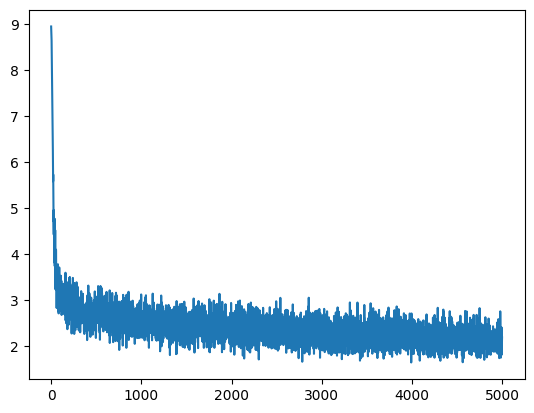

In [164]:
plt.plot(all_losses)

In [165]:
evalModel = EvaluateMode(encoder, decoder)
evalModel.eval()


evalModel.evaluate(voc, "to do")

['i', 'm', 'not', 'going', 'to', 'go', '.', '<EOS>', '<PAD>', '<PAD>']

In [166]:

eval_batch = [random.choice(pairs) for _ in range(10)]

for pair in eval_batch:
    generated = ' '.join(evalModel.evaluate(voc, pair[0]))
    print(f"> {pair[0]}")
    print(f"= {pair[1]}")
    print(f">> {generated}")


> yea art thou there ?
= put more into it !
>> i m not a little . <EOS> <PAD> <PAD> <PAD>
> she needed it .
= a tip ! for the housekeeper !
>> i m not going to go . <EOS> <PAD> <PAD>
> how about that .
= mmmm . you have children ?
>> i m not going to be . <EOS> <PAD> <PAD>
> yeah .
= god ! unbelievable . vampires .
>> you re not going to be here . <EOS> <PAD>
> any minute now .
= it s show time . don t look at
>> i m not going to be . <EOS> <PAD> <PAD>
> that s not why he s sending me .
= why then .
>> i m not going to go . <EOS> <PAD> <PAD>
> a lot that means .
= grace tell him .
>> what ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
> stop it .
= i swear .
>> what ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
> well we ll have breakfast in the garden .
= um hum . . .
>> i m not going to go . <EOS> <PAD> <PAD>
> we ll be there .
= goodnight .
>> i m not going to be . <EOS> <PAD> <PAD>


In [168]:
hidden_size = 256
encoder_n_layers = 2
decoder_n_layers = 3
dropout = 0.1
batch_size = 32
attn_mode = 'general'

embedding = nn.Embedding(voc.n_words, hidden_size)
encoder = EncoderGru(embedding, hidden_size, encoder_n_layers, dropout)
decoder = AttnDecoderGru(attn_mode, embedding, hidden_size, enc_layers=encoder_n_layers,
                     n_layers=decoder_n_layers, output_size=voc.n_words, dropout_p=dropout)

clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 5000
print_every = 200

embedding.train()
encoder.train()
decoder.train()

embedding_optimizer = torch.optim.Adam(embedding.parameters(), lr=learning_rate)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)

print_loss = 0
all_losses = []

for iteration in range(1, n_iteration + 1):
    batch_data = batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
    
    loss, n_mask = train_batch(batch_data, encoder, decoder, embedding,
                encoder_optimizer, decoder_optimizer, embedding_optimizer,
                clip, teacher_forcing_ratio)
    
    all_losses.append(loss)
    print_loss += loss

    if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

Iteration: 200; Percent complete: 4.0%; Average loss: 3.4260
Iteration: 400; Percent complete: 8.0%; Average loss: 2.7270
Iteration: 600; Percent complete: 12.0%; Average loss: 2.6025
Iteration: 800; Percent complete: 16.0%; Average loss: 2.5226
Iteration: 1000; Percent complete: 20.0%; Average loss: 2.4298
Iteration: 1200; Percent complete: 24.0%; Average loss: 2.3901
Iteration: 1400; Percent complete: 28.0%; Average loss: 2.3267
Iteration: 1600; Percent complete: 32.0%; Average loss: 2.2926
Iteration: 1800; Percent complete: 36.0%; Average loss: 2.2949
Iteration: 2000; Percent complete: 40.0%; Average loss: 2.2915
Iteration: 2200; Percent complete: 44.0%; Average loss: 2.2425
Iteration: 2400; Percent complete: 48.0%; Average loss: 2.2368
Iteration: 2600; Percent complete: 52.0%; Average loss: 2.1852
Iteration: 2800; Percent complete: 56.0%; Average loss: 2.1792
Iteration: 3000; Percent complete: 60.0%; Average loss: 2.1514
Iteration: 3200; Percent complete: 64.0%; Average loss: 2.122

In [169]:
evalModel = EvaluateMode(encoder, decoder)
evalModel.eval()

eval_batch = [random.choice(pairs) for _ in range(10)]

for pair in eval_batch:
    generated = ' '.join(evalModel.evaluate(voc, pair[0]))
    print("====================")
    print(f"> {pair[0]}")
    print(f"= {pair[1]}")
    print(f">> {generated}")

> don t be ridiculous .
= i have your word mister president ?
>> i m sorry . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD>
> shes your dog jack .
= no shes not .
>> what ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
> i don t know . . .
= i want his name .
>> i don t know . <EOS> <PAD> <PAD> <PAD> <PAD>
> yeah but where s the third guy ?
= not in the bedroom . do it !
>> i don t know . <EOS> <PAD> <PAD> <PAD> <PAD>
> bye .
= bye .
>> hi . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
> i m not myself since i stopped smoking .
= oh when d you quit smoking ?
>> what ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
> somebody hit you ?
= it s not what you think .
>> yeah . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
> what s in here then lead ?
= it s my mother s piano .
>> i don t know . <EOS> <PAD> <PAD> <PAD> <PAD>
> yeah i crash there .
= yeah good .
>> you re not a good man . <EOS> <PAD> <PAD>
> alright !
= could take a little while though .
>> i m sorry . <EOS> <PAD> <PAD> <PAD> <P

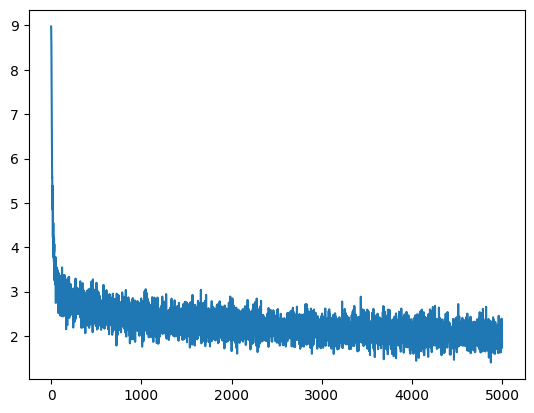

In [170]:
plt.plot(all_losses)